# Libraries and modules imported

In [117]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import requests
import sklearn
import zipfile, io
import sklearn
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [118]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [120]:
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

In [121]:
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [122]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
!pip install -q findspark


In [125]:
!pip install pyspark

In [126]:
import findspark
findspark.init()

In [127]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()


# Extracting data from the database file

In [128]:
folder_name = r'../data'

# make a folder if it doesn't already exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# pass the url for the zipfile from data.gov
url = r'https://ed-public-download.app.cloud.gov/downloads/CollegeScorecard_Raw_Data.zip'
response = requests.get(url, stream = True)

# extract contents
with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
    for elem in zf.namelist():
        zf.extract(elem, '../data')

In [129]:
df = pd.read_csv('../data/CollegeScorecard_Raw_Data/MERGED2014_15_PP.csv', low_memory = False)

In [134]:
#Here we are selecting only certain columns thats required for this analysis
df = df[["UNITID","SAT_AVG","INSTNM","ACTENMID","ACTMTMID","ACTWRMID","TUITIONFEE_PROG",
          "MD_EARN_WNE_P10","UNEMP_RATE","MD_EARN_WNE_P6","ADM_RATE","TUITIONFEE_IN","TUITIONFEE_OUT","CONTROL","STABBR"]]

#Exploratory data analysis
Before we begin we need to understand our data thoroughly. Here is the summary of the data

In [135]:
df.head(3)

,UNITID,SAT_AVG,INSTNM,ACTENMID,ACTMTMID,ACTWRMID,TUITIONFEE_PROG,MD_EARN_WNE_P10,UNEMP_RATE,MD_EARN_WNE_P6,ADM_RATE,TUITIONFEE_IN,TUITIONFEE_OUT,CONTROL,STABBR
0,100654,827.0,Alabama A & M University,17.0,17.0,NaN,NaN,31000,NaN,25200,0.5256,9096.0,16596.0,1,AL
1,100663,1107.0,University of Alabama at Birmingham,25.0,23.0,NaN,NaN,41200,NaN,35100,0.8569,7510.0,17062.0,1,AL
2,100690,NaN,Amridge University,NaN,NaN,NaN,NaN,39600,NaN,30700,NaN,6900.0,6900.0,2,AL


In [136]:
df.dtypes

UNITID               int64
SAT_AVG            float64
INSTNM              object
ACTENMID           float64
ACTMTMID           float64
ACTWRMID           float64
TUITIONFEE_PROG    float64
MD_EARN_WNE_P10     object
UNEMP_RATE         float64
MD_EARN_WNE_P6      object
ADM_RATE           float64
TUITIONFEE_IN      float64
TUITIONFEE_OUT     float64
CONTROL              int64
STABBR              object
dtype: object

In [139]:
df.describe()

,UNITID,SAT_AVG,ACTENMID,ACTMTMID,ACTWRMID,TUITIONFEE_PROG,UNEMP_RATE,ADM_RATE,TUITIONFEE_IN,TUITIONFEE_OUT,CONTROL
count,7.766000e+03,1314.000000,1118.000000,1120.000000,303.000000,2800.000000,0.0,2214.000000,4407.000000,4205.000000,7766.000000
mean,1.652103e+06,1059.910198,22.884615,22.681250,7.792079,15129.754643,NaN,0.693272,14148.197413,16734.086326,2.213881
std,6.541349e+06,133.585773,3.868949,3.449004,1.016260,7304.280345,NaN,0.208325,10988.968703,10241.052811,0.835292
min,1.006540e+05,720.000000,13.000000,13.000000,4.000000,200.000000,NaN,0.000000,0.000000,580.000000,1.000000
25%,1.742375e+05,974.000000,20.000000,21.000000,7.000000,11515.000000,NaN,0.566850,5277.500000,8984.000000,1.000000
50%,2.305435e+05,1040.000000,22.000000,22.000000,8.000000,14985.000000,NaN,0.715050,12204.000000,14400.000000,2.000000
75%,4.477198e+05,1122.000000,25.000000,24.000000,9.000000,17200.000000,NaN,0.846200,18048.000000,21160.000000,3.000000
max,4.841450e+07,1545.000000,35.000000,36.000000,12.000000,88550.000000,NaN,1.000000,74787.000000,74787.000000,3.000000


In [140]:
df.count()

UNITID             7766
SAT_AVG            1314
INSTNM             7766
ACTENMID           1118
ACTMTMID           1120
ACTWRMID            303
TUITIONFEE_PROG    2800
MD_EARN_WNE_P10    6951
UNEMP_RATE            0
MD_EARN_WNE_P6     6951
ADM_RATE           2214
TUITIONFEE_IN      4407
TUITIONFEE_OUT     4205
CONTROL            7766
STABBR             7766
dtype: int64

#Descriptive Statistics
A histogram will be drawn for each
of the numerical variables in order to see the data distribution
as well as to detect any outliers. Bar plots will be utilized
for non-numerical variables. We examine the data distribution
in order to have a better understanding of our data and to
draw inferences from it. For example, we may determine
whether the data are comparable or where the majority of
the data converge, while glancing at the mean value is not
always sufficient because the mean can be readily influenced
by outliers.


A short description of the data (max value, min value,
standard deviation, etc.) is given for each graph, as well as
the variance of the data. Variance near to 0 indicates that
the majority of the data is similar, whereas large variance
indicates that the majority of the data is dissimilar. As a
result, by considering the variance value, we may eliminate
characteristics that provide minimal information. It’s important
to remember that the data must first be normalized before the
variance can be calculated.

In [141]:
min_max_scaler = preprocessing.MinMaxScaler() #For normalization
# Clean NaN values from the variable we want to check
def cleanVariable(variable_to_check):
    df_SAT = df.copy()
    print(df_SAT[variable_to_check])
    df_SAT = df_SAT[df_SAT[variable_to_check]>0]
    print(df_SAT)
    return df_SAT

0        827.0
1       1107.0
2          NaN
3       1219.0
4        851.0
         ...  
7761       NaN
7762       NaN
7763       NaN
7764       NaN
7765       NaN
Name: SAT_AVG, Length: 7766, dtype: float64
      UNITID  SAT_AVG  ... CONTROL  STABBR
0     100654    827.0  ...       1      AL
1     100663   1107.0  ...       1      AL
3     100706   1219.0  ...       1      AL
4     100724    851.0  ...       1      AL
5     100751   1185.0  ...       1      AL
...      ...      ...  ...     ...     ...
7001  479956   1040.0  ...       1      PA
7138  482149   1030.0  ...       1      GA
7185  482680   1016.0  ...       1      GA
7287  484473   1156.0  ...       1      FL
7313  484905    887.0  ...       1      TX

[1314 rows x 15 columns]


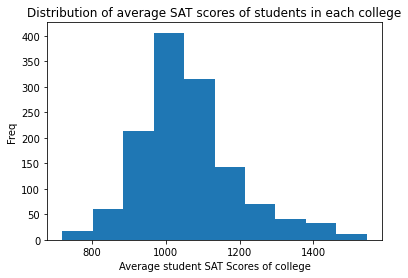

Variance:  0.026198828918322342
           SAT_AVG
count  1314.000000
mean   1059.910198
std     133.585773
min     720.000000
25%     974.000000
50%    1040.000000
75%    1122.000000
max    1545.000000
[[0.12969697]
 [0.46909091]
 [0.60484848]
 ...
 [0.35878788]
 [0.52848485]
 [0.20242424]]


In [142]:
variable_to_check = "SAT_AVG"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=10)
plt.xlabel("Average student SAT Scores of college")
plt.ylabel("Freq")
plt.title("Distribution of average SAT scores of students in each college")
plt.show()

print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[[variable_to_check]])))
print(dfplt[[variable_to_check]].describe())
print (min_max_scaler.fit_transform(dfplt[[variable_to_check]]))

We may deduce from the histogram of the distribution of
average SAT scores of college students that if you have an
overall SAT score of about 900- 1200, you will likely be
accepted to most colleges. However, based on the histogram.

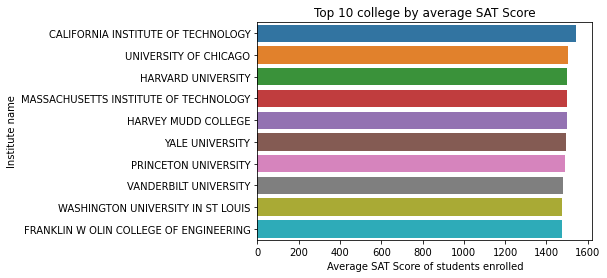

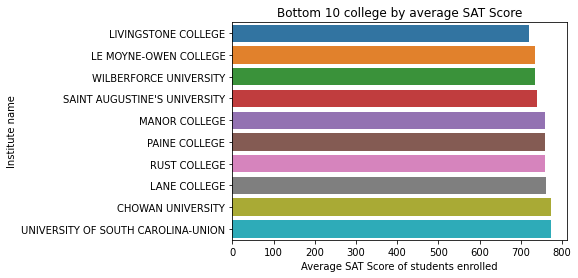

In [143]:
dff = df.copy()
dff = dff[dff["SAT_AVG"] > 0]
dff["INSTNM"] = dff["INSTNM"].str.upper()
dff.drop_duplicates("INSTNM", inplace=True)
a = dff.sort_values('SAT_AVG', ascending=False).head(10)
sns.barplot(a["SAT_AVG"], a["INSTNM"], orient="h")
plt.ylabel("Institute name")
plt.xlabel("Average SAT Score of students enrolled")
plt.title("Top 10 college by average SAT Score")
plt.show()

b = dff.sort_values('SAT_AVG', ascending=True).head(10)
sns.barplot(b["SAT_AVG"], b["INSTNM"], orient="h")
plt.ylabel("Institute name")
plt.xlabel("Average SAT Score of students enrolled")
plt.title("Bottom 10 college by average SAT Score")
plt.show()

We can observe that students at schools and universities
such as Harvard and the Massachusetts Institute of Technology
have relatively high SAT scores. This information is valuable
for students who wish to apply to these colleges and want to
improve their SAT scores in order to have a better chance of
being accepted.

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
7761        NaN
7762        NaN
7763    12000.0
7764        NaN
7765     7000.0
Name: TUITIONFEE_PROG, Length: 7766, dtype: float64
        UNITID  SAT_AVG  ... CONTROL  STABBR
18      101277      NaN  ...       3      AL
66      102711      NaN  ...       1      AK
68      103501      NaN  ...       3      AK
71      103732      NaN  ...       3      AZ
72      103741      NaN  ...       3      AZ
...        ...      ...  ...     ...     ...
7758  47657701      NaN  ...       3      TX
7759  47657702      NaN  ...       3      TX
7760  47691101      NaN  ...       3      CA
7763  48387801      NaN  ...       3      CA
7765  48414501      NaN  ...       3      TX

[2800 rows x 15 columns]


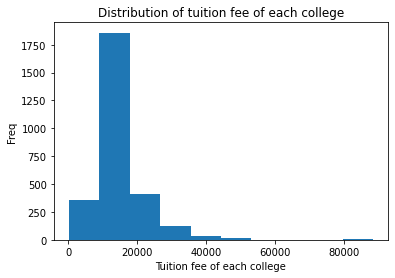

Variance:  0.006832609907138167
       TUITIONFEE_PROG
count      2800.000000
mean      15129.754643
std        7304.280345
min         200.000000
25%       11515.000000
50%       14985.000000
75%       17200.000000
max       88550.000000


In [144]:
variable_to_check = "TUITIONFEE_PROG"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=10)
plt.xlabel("Tuition fee of each college")
plt.ylabel("Freq")
plt.title("Distribution of tuition fee of each college")
plt.show()

print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[[variable_to_check]]))) 
print(dfplt[[variable_to_check]].describe())

Looking at the histogram of tuition charge distribution, we
can see that tuition fees are quite low for most universities,
with most colleges charging less than the national average.

0        9096.0
1        7510.0
2        6900.0
3        9158.0
4        8720.0
         ...   
7761    10764.0
7762        NaN
7763        NaN
7764    29932.0
7765        NaN
Name: TUITIONFEE_IN, Length: 7766, dtype: float64
        UNITID  SAT_AVG  ... CONTROL  STABBR
0       100654    827.0  ...       1      AL
1       100663   1107.0  ...       1      AL
2       100690      NaN  ...       2      AL
3       100706   1219.0  ...       1      AL
4       100724    851.0  ...       1      AL
...        ...      ...  ...     ...     ...
7754  45897307      NaN  ...       3      TX
7755  45897308      NaN  ...       3      TX
7756  45920401      NaN  ...       3      CA
7761  48065701      NaN  ...       3      KS
7764  48400201      NaN  ...       3      CA

[4406 rows x 15 columns]


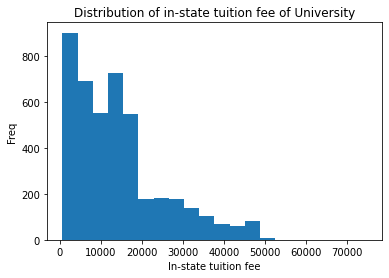

Variance:  0.021921015293979364
       TUITIONFEE_IN
count    4406.000000
mean    14151.408534
std     10988.147918
min       580.000000
25%      5282.750000
50%     12204.000000
75%     18048.000000
max     74787.000000
0       16596.0
1       17062.0
2        6900.0
3       21232.0
4       15656.0
         ...   
7761        NaN
7762        NaN
7763        NaN
7764        NaN
7765        NaN
Name: TUITIONFEE_OUT, Length: 7766, dtype: float64
        UNITID  SAT_AVG  ... CONTROL  STABBR
0       100654    827.0  ...       1      AL
1       100663   1107.0  ...       1      AL
2       100690      NaN  ...       2      AL
3       100706   1219.0  ...       1      AL
4       100724    851.0  ...       1      AL
...        ...      ...  ...     ...     ...
7584  22797902      NaN  ...       1      TX
7589  23059701      NaN  ...       1      UT
7601  23693901      NaN  ...       1      WA
7603  23693903      NaN  ...       1      WA
7605  24366501      NaN  ...       1      VI

[4205 rows 

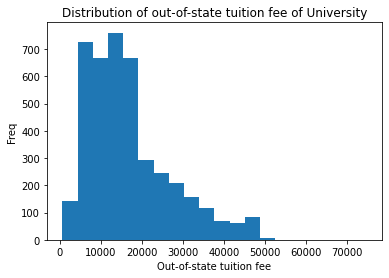

Variance:  0.019041281326944267
       TUITIONFEE_OUT
count     4205.000000
mean     16734.086326
std      10241.052811
min        580.000000
25%       8984.000000
50%      14400.000000
75%      21160.000000
max      74787.000000


In [145]:
variable_to_check = "TUITIONFEE_IN"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=20)
plt.xlabel("In-state tuition fee")
plt.ylabel("Freq")
plt.title("Distribution of in-state tuition fee of University")
plt.show()
print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[[variable_to_check]]))) 
print(dfplt[[variable_to_check]].describe())

variable_to_check = "TUITIONFEE_OUT"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=20)
plt.xlabel("Out-of-state tuition fee")
plt.ylabel("Freq")
plt.title("Distribution of out-of-state tuition fee of University")
plt.show()
print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[[variable_to_check]]))) 
print(dfplt[[variable_to_check]].describe())

In-state and out-of-state college tuition fees are just slightly
different. Furthermore, the histogram reveals that certain outliers exist for both variables. Before eliminating the outlier,
we’ll go deeper into the variable.

        UNITID  SAT_AVG  ... CONTROL  STABBR
0       100654    827.0  ...       1      AL
1       100663   1107.0  ...       1      AL
2       100690      NaN  ...       2      AL
3       100706   1219.0  ...       1      AL
4       100724    851.0  ...       1      AL
...        ...      ...  ...     ...     ...
7761  48065701      NaN  ...       3      KS
7762  48154401      NaN  ...       3      OH
7763  48387801      NaN  ...       3      CA
7764  48400201      NaN  ...       3      CA
7765  48414501      NaN  ...       3      TX

[7766 rows x 15 columns]


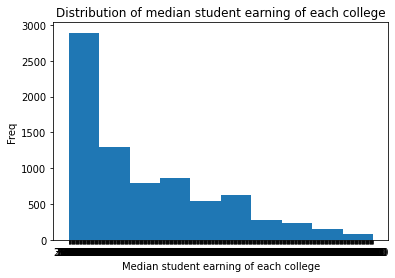

Variance:  0.013219851235900212
       MD_EARN_WNE_P6
count            7766
unique            529
top                 0
freq             1448


In [147]:
variable_to_check = "MD_EARN_WNE_P6"
df['MD_EARN_WNE_P6']
#dfplt = cleanVariable(variable_to_check)

dfplt = df.copy()
dfplt[variable_to_check] = dfplt[variable_to_check].replace(np.nan, '0')
dfplt[variable_to_check] = dfplt[variable_to_check].replace('PrivacySuppressed', '0')
print(dfplt)

plt.hist(dfplt[variable_to_check], bins=10)
plt.xlabel("Median student earning of each college")
plt.ylabel("Freq")
plt.title("Distribution of median student earning of each college")
plt.show()


print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[[variable_to_check]]))) 
print(dfplt[[variable_to_check]].describe())

We can estimate that most students’ salaries
after graduation will be in the range of 30k to 40k.
However, there are some clear outliers, such as
a college graduate’s maximum median salary of
127300.

Text(0.5, 1.0, 'Top 10 college by Median earning')

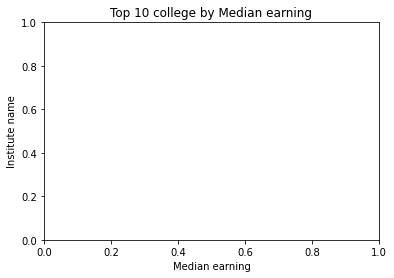

In [152]:
dff = df.copy()
#dff = dff[dff["MD_EARN_WNE_P6"] > 0]
dff["INSTNM"] = dff["INSTNM"].str.upper()
dff.drop_duplicates("INSTNM", inplace=True)
a = dff.sort_values('MD_EARN_WNE_P6', ascending=False).head(10)
#sns.barplot(a["MD_EARN_WNE_P6"], a["INSTNM"], orient="h")
plt.ylabel("Institute name")
plt.xlabel("Median earning")
plt.title("Top 10 college by Median earning")
#plt.show()



When utilizing a barplot, the outlier isn’t that notable when
compared to the second highest. Because the top five universities are all linked to health and pharmacy, this barplot also
indicates that health sciences or pharmacy-related employment
may be among the highest-paying jobs in the US. To prove
the hypothesis, more research is necessary.

0       0.5256
1       0.8569
2          NaN
3       0.8203
4       0.5326
         ...  
7761       NaN
7762       NaN
7763       NaN
7764       NaN
7765       NaN
Name: ADM_RATE, Length: 7766, dtype: float64
      UNITID  SAT_AVG  ... CONTROL  STABBR
0     100654    827.0  ...       1      AL
1     100663   1107.0  ...       1      AL
3     100706   1219.0  ...       1      AL
4     100724    851.0  ...       1      AL
5     100751   1185.0  ...       1      AL
...      ...      ...  ...     ...     ...
7284  484376      NaN  ...       3      CA
7287  484473   1156.0  ...       1      FL
7313  484905    887.0  ...       1      TX
7322  485078      NaN  ...       2      AZ
7334  485272      NaN  ...       3      FL

[2211 rows x 15 columns]


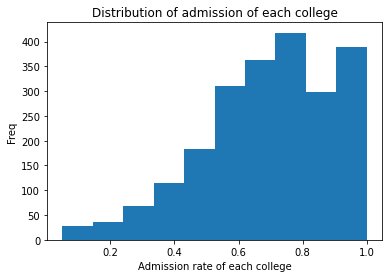

Rate of NaN:  71.52974504249292 %
Value count:
1.0000    145
0.6667     15
0.5000      7
0.7143      6
0.7500      6
         ... 
0.6947      1
0.7209      1
0.7864      1
0.6267      1
0.6531      1
Name: ADM_RATE, Length: 1723, dtype: int64

          ADM_RATE
count  2211.000000
mean      0.694212
std       0.206894
min       0.050500
25%       0.567400
50%       0.715300
75%       0.846200
max       1.000000


In [153]:
variable_to_check = "ADM_RATE"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check])
plt.xlabel("Admission rate of each college")
plt.ylabel("Freq")
plt.title("Distribution of admission of each college")
plt.show()
print("Rate of NaN: ", (len(df)-len(dfplt))/len(df)*100, "%")
print("Value count:")
print(dfplt[variable_to_check].value_counts())
print()
print(dfplt[[variable_to_check]].describe())
#print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[[variable_to_check]]))) 

Almost 98 percent of ADM RATE data is NaN values, and
the variance is likewise modest, implying that the vast bulk of
the data is identical. As a result, we choose to disregard this
characteristic because it is irrelevant to our study.

0       17.0
1       25.0
2        NaN
3       28.0
4       17.0
        ... 
7761     NaN
7762     NaN
7763     NaN
7764     NaN
7765     NaN
Name: ACTENMID, Length: 7766, dtype: float64
      UNITID  SAT_AVG  ... CONTROL  STABBR
0     100654    827.0  ...       1      AL
1     100663   1107.0  ...       1      AL
3     100706   1219.0  ...       1      AL
4     100724    851.0  ...       1      AL
5     100751   1185.0  ...       1      AL
...      ...      ...  ...     ...     ...
7001  479956   1040.0  ...       1      PA
7138  482149   1030.0  ...       1      GA
7185  482680   1016.0  ...       1      GA
7287  484473   1156.0  ...       1      FL
7313  484905    887.0  ...       1      TX

[1118 rows x 15 columns]


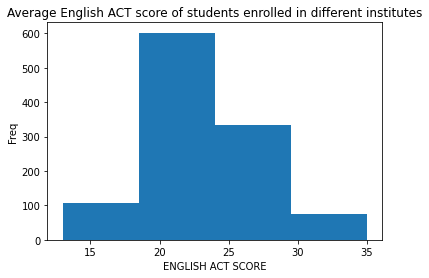

Variance:  0.030899546461019868
          ACTENMID
count  1118.000000
mean     22.884615
std       3.868949
min      13.000000
25%      20.000000
50%      22.000000
75%      25.000000
max      35.000000


In [154]:
variable_to_check = "ACTENMID"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=4)
plt.xlabel("ENGLISH ACT SCORE")
plt.ylabel("Freq")
plt.title("Average English ACT score of students enrolled in different institutes")
plt.show()

print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[[variable_to_check]]))) 
print(dfplt[[variable_to_check]].describe())

Every ACT is graded on a scale of 1 to 36, with 1 being
the lowest possible score. As a result, there is no issue with
this functionality. The majority of pupils had a 22-point ACT
English score.

0       17.0
1       23.0
2        NaN
3       26.0
4       17.0
        ... 
7761     NaN
7762     NaN
7763     NaN
7764     NaN
7765     NaN
Name: ACTMTMID, Length: 7766, dtype: float64
      UNITID  SAT_AVG  ... CONTROL  STABBR
0     100654    827.0  ...       1      AL
1     100663   1107.0  ...       1      AL
3     100706   1219.0  ...       1      AL
4     100724    851.0  ...       1      AL
5     100751   1185.0  ...       1      AL
...      ...      ...  ...     ...     ...
7001  479956   1040.0  ...       1      PA
7138  482149   1030.0  ...       1      GA
7185  482680   1016.0  ...       1      GA
7287  484473   1156.0  ...       1      FL
7313  484905    887.0  ...       1      TX

[1120 rows x 15 columns]


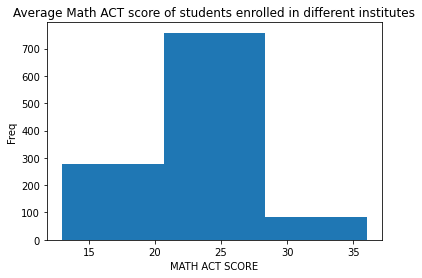

Variance:  0.02246692926343505
          ACTMTMID
count  1120.000000
mean     22.681250
std       3.449004
min      13.000000
25%      21.000000
50%      22.000000
75%      24.000000
max      36.000000


In [155]:
variable_to_check = "ACTMTMID"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=3)
plt.xlabel("MATH ACT SCORE")
plt.ylabel("Freq")
plt.title("Average Math ACT score of students enrolled in different institutes")
plt.show()

print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[[variable_to_check]]))) 
print(dfplt[[variable_to_check]].describe())

Every ACT is graded on a scale of 1 to 36, with 1 being the
lowest possible score.Looking at the plot and the data, there
is one instance when the ACT Math score is merely 1. We
determined that this is not an exception; the lowest possible
ACT test score is 1.

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
7761   NaN
7762   NaN
7763   NaN
7764   NaN
7765   NaN
Name: ACTWRMID, Length: 7766, dtype: float64
      UNITID  SAT_AVG  ... CONTROL  STABBR
5     100751   1185.0  ...       1      AL
9     100858   1215.0  ...       1      AL
51    102094   1048.0  ...       1      AL
211   109785   1037.0  ...       2      CA
275   111948   1210.0  ...       2      CA
...      ...      ...  ...     ...     ...
5956  449764   1031.0  ...       2      TN
6096  451671   1105.0  ...       1      FL
6347  456959   1112.0  ...       1      MN
7001  479956   1040.0  ...       1      PA
7287  484473   1156.0  ...       1      FL

[303 rows x 15 columns]


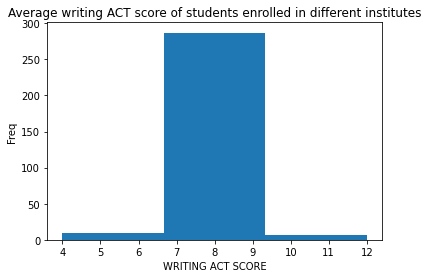

Variance:  0.016084003202300426
         ACTWRMID
count  303.000000
mean     7.792079
std      1.016260
min      4.000000
25%      7.000000
50%      8.000000
75%      9.000000
max     12.000000


In [156]:
variable_to_check = "ACTWRMID"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=3)
plt.xlabel("WRITING ACT SCORE")
plt.ylabel("Freq")
plt.title("Average writing ACT score of students enrolled in different institutes")
plt.show()

print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[[variable_to_check]]))) 
print(dfplt[[variable_to_check]].describe())

Every ACT is graded on a scale of 1 to 36, with 1 being the
lowest possible score. In this feature, there is an exceptional
case with a score of 530 whereas the lowest attainable score
is merely 36. It will be deleted from the row with which it is
related.

In [159]:
#Removing the outlier
df_copy = df[df["ACTWRMID"] != 530]

We want to see the top 10 institutes with the highest ACT
score after cleaning the ACT data

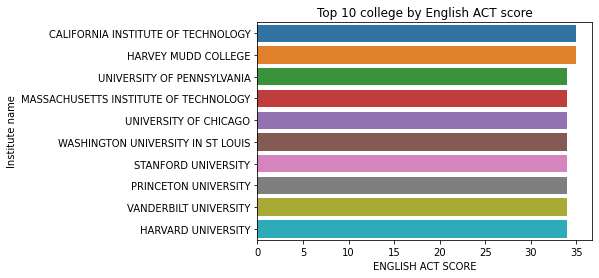

In [160]:
dff = df_copy.copy()
dff = dff[dff["ACTENMID"] > 0]
dff["INSTNM"] = dff["INSTNM"].str.upper()
dff.drop_duplicates("INSTNM", inplace=True)
a = dff.sort_values('ACTENMID', ascending=False).head(10)
sns.barplot(a["ACTENMID"], a["INSTNM"], orient="h")
plt.ylabel("Institute name")
plt.xlabel("ENGLISH ACT SCORE")
plt.title("Top 10 college by English ACT score")
plt.show()

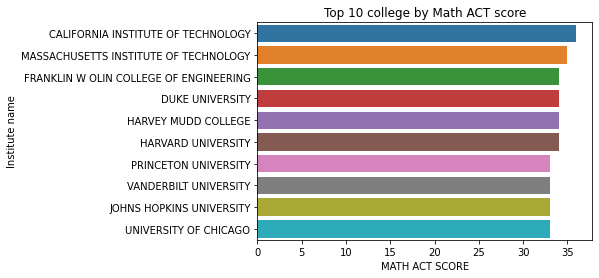

In [161]:
dff = df_copy.copy()
dff = dff[dff["ACTMTMID"] > 0]
dff["INSTNM"] = dff["INSTNM"].str.upper()
dff.drop_duplicates("INSTNM", inplace=True)
a = dff.sort_values('ACTMTMID', ascending=False).head(10)
sns.barplot(a["ACTMTMID"], a["INSTNM"], orient="h")
plt.ylabel("Institute name")
plt.xlabel("MATH ACT SCORE")
plt.title("Top 10 college by Math ACT score")
plt.show()

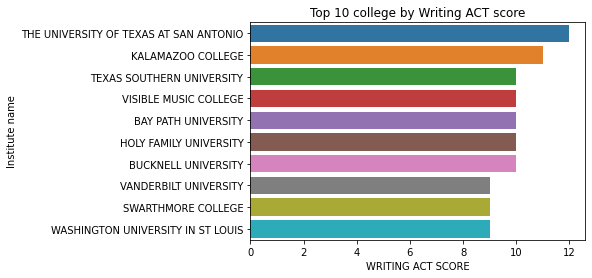

In [162]:
dff = df_copy.copy()
dff = dff[dff["ACTWRMID"] > 0]
dff["INSTNM"] = dff["INSTNM"].str.upper()
dff.drop_duplicates("INSTNM", inplace=True)
a = dff.sort_values('ACTWRMID', ascending=False).head(10)
sns.barplot(a["ACTWRMID"], a["INSTNM"], orient="h")
plt.ylabel("Institute name")
plt.xlabel("WRITING ACT SCORE")
plt.title("Top 10 college by Writing ACT score")
plt.show()

We can claim that schools like MIT and Harvard made it
on the charts in Math and English ACT scores based on these
three bar plots of the top 10 institutes with highest ACT scores
in writing, math, and English.

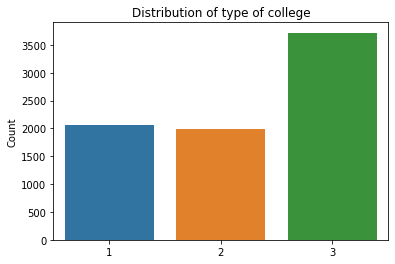

3    3717
1    2056
2    1993
Name: CONTROL, dtype: int64


In [163]:
variable_to_check = "CONTROL"
dfplt = df_copy.copy()

sns.barplot( dfplt[variable_to_check].value_counts().index, dfplt[variable_to_check].value_counts() )
plt.ylabel("Count")
plt.title("Distribution of type of college")
plt.show()
print(dfplt[variable_to_check].value_counts())

We may deduce from the distribution of college types that
the majority of institutions in the United States are private nonprofit. The majority are private for-profit businesses.

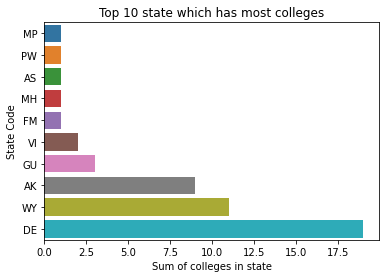

In [164]:
asd = df_copy.copy()
asd = asd[['INSTNM','STABBR']]
asdd = asd.groupby('STABBR').count().sort_values('INSTNM').head(10)

sns.barplot(asdd["INSTNM"] , asdd.index ,orient="h")
plt.ylabel("State Code")
plt.xlabel("Sum of colleges in state")
plt.title("Top 10 state which has most colleges")
plt.show()

## Data Mining
Here we attempt to find patterns and relationship among the
features in the data set available.

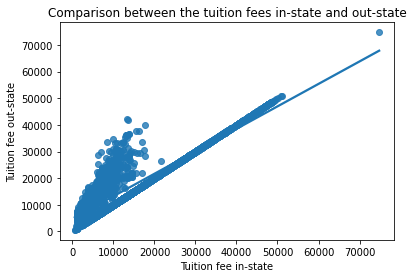

In [165]:
inout = df_copy.copy()
inout = inout[(inout.TUITIONFEE_IN > 0) & (inout.TUITIONFEE_OUT > 0)]
inout = inout[['TUITIONFEE_IN','TUITIONFEE_OUT','CONTROL']]
sns.regplot(inout.TUITIONFEE_IN,inout.TUITIONFEE_OUT,scatter=True,fit_reg=True)
plt.xlabel("Tuition fee in-state")
plt.ylabel("Tuition fee out-state")
plt.title("Comparison between the tuition fees in-state and out-state")
plt.show()

It appears that there are two sets of data points, where only
data points are precisely aligned on the x=y line, indicating
that both institutions’ tuition fees are the same. We may deduce
from this graph that certain universities may charge out-ofstate students a greater tuition rate

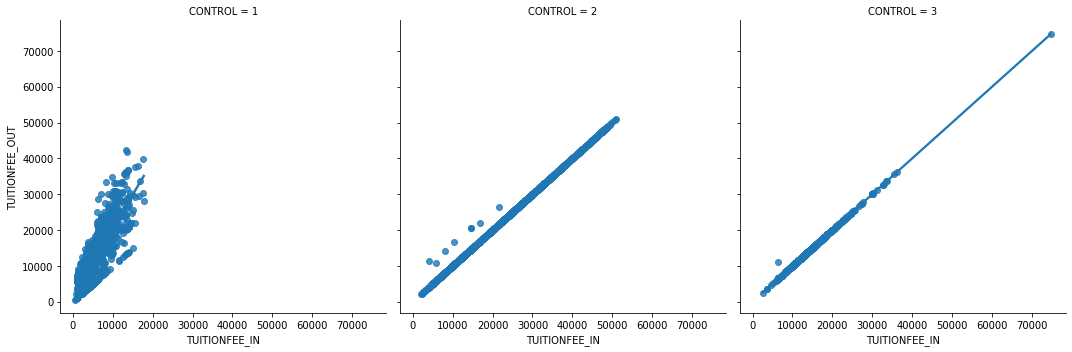

In [166]:
sns.lmplot(x="TUITIONFEE_IN",y="TUITIONFEE_OUT",col="CONTROL",data = inout,truncate=True)
plt.show()

According to the graph above, approximately 30% of private for-profit and 55% of private non-profit share the same fee cost for both in-state and out-of-state study, while only 5% of public institutions share the same fee. The plot indicates how many points are on the line.

In [167]:
inout.groupby('CONTROL').mean()

,TUITIONFEE_IN,TUITIONFEE_OUT
CONTROL,,
1,5155.611940,11606.460896
2,23874.374570,23906.045361
3,15012.125581,15016.479070


After analysis for all of the institution, we further our analysis to calculate the mean for both in and outstate tution fee cost.There is almost no in-state out-state fee difference for private instituions while for public institutions the out state fee is approximate twice compare with instate fee. <br><br>

In [168]:
asd = df_copy.copy()
asd = asd[asd['UNEMP_RATE']>0]
asd = asd[['INSTNM','STABBR','UNEMP_RATE']]

asd["INSTNM"] = asd["INSTNM"].str.upper()
asd = asd.sort_values('UNEMP_RATE',ascending=False)
asd.drop_duplicates("INSTNM", inplace=True)
asd.head(5)

,INSTNM,STABBR,UNEMP_RATE


From the table, we are able to find out the institute with the top 5 highest unemployment rate, these are probably the college that we gonna avoid as we would want a low unemployment rate college.

## Which sector of ACT scores contributes the most to the income?
Here we will explore linear regression model.

In [ ]:
dfplt = df_copy.copy()
dfplt = dfplt[(dfplt.ACTENMID > 0)  & (dfplt.ACTMTMID > 0) & (dfplt.ACTWRMID > 0) & (dfplt['MD_EARN_WNE_P6']>0)]
math = plt.plot(dfplt['ACTMTMID'], dfplt.MD_EARN_WNE_P6, 'ro', label = "math")
writing = plt.plot(dfplt['ACTWRMID'], dfplt.MD_EARN_WNE_P6, 'go', label = "writing")
english = plt.plot(dfplt['ACTENMID'], dfplt.MD_EARN_WNE_P6, 'bo', label = "english")
plt.title("Relationship between ACT and Earning")
plt.xlabel("ACT")
plt.ylabel("Earning")
plt.legend()
plt.show()

We could see from the plot above that ACT scores may
have a big impact on future earnings. As a result, for the time
being, it may be appropriate for training our prediction model.

## Does tuition fee really affect the income of a student once they graduate?

In [ ]:
Sat_6yEarn = df_copy[(df_copy.SAT_AVG > 0) & (df_copy.MD_EARN_WNE_P6 > 0) ]
plt.scatter(Sat_6yEarn['SAT_AVG'], Sat_6yEarn['MD_EARN_WNE_P6'])
plt.xlabel('SAT_AVG')
plt.ylabel('MD_EARN_WNE_P6')
plt.title("Relationship  between Average SAT Score and Earning")
plt.xlabel("Average SAT Score")
plt.ylabel("Earning")
plt.show()

#clearly an increasing sign

## Does tuition fee really affect the income of a student once they graduate?

In [ ]:
#find if Tuition fee affect Earning
Tui_6yEarn = df_copy[(df_copy.TUITIONFEE_PROG > 0) & (df_copy.MD_EARN_WNE_P6 > 0) ]
plt.scatter(Tui_6yEarn['TUITIONFEE_PROG'], Tui_6yEarn['MD_EARN_WNE_P6'])
plt.xlabel('Tuition Fee')
plt.ylabel('Earning')
plt.title("Relationship  between Tuition Fee and Earning")
plt.show()


In [ ]:
ACT3_6yEarn = df_copy[(df_copy.ACTENMID > 0)  & (df_copy.ACTMTMID > 0) & (df_copy.ACTWRMID > 0) & (df_copy.MD_EARN_WNE_P6 > 0) ]
acs = ACT3_6yEarn.sort_values(['ACTENMID', 'ACTMTMID', 'ACTWRMID'], ascending = False).head(10)
des = ACT3_6yEarn.sort_values(['ACTENMID', 'ACTMTMID', 'ACTWRMID'], ascending = True).head(10)
top = plt.plot(acs['MD_EARN_WNE_P6'],'ro', label="Top10")
btn = plt.plot(des['MD_EARN_WNE_P6'],'bo', label="Worst10")  

plt.title("Top10 ACT score compare with Worst10 ACT score(Earning in 6 years)")
plt.legend()
plt.ylabel('Earning')
plt.show()
#red mean the top 10 ACT score in read, writing and english
#blue mean the least 10 ACT score in read, writing and english
#clearly we can know that red earn high than blue

## What are the prospects of earning in a private college compared to a public one?

In [ ]:
public = df_copy[(df_copy.CONTROL == 'Public')]
private_np = df_copy[(df_copy.CONTROL == 'Private nonprofit')]
private_p = df_copy[(df_copy.CONTROL == 'Private for-profit')]
public = public[public.MD_EARN_WNE_P6 > 0]
private_np = private_np[private_np.MD_EARN_WNE_P6 > 0]
private_p = private_p[private_p.MD_EARN_WNE_P6 > 0]
x = sum(public['MD_EARN_WNE_P6'])/sen(public)
y = sum(private_np['MD_EARN_WNE_P6'])/len(private_np)
z = sum(private_p['MD_EARN_WNE_P6'])/len(private_p)
dictionary = plt.figure()

D = {u'Public':x, u'Private for non profit': y, u'Private for profit':z}

plt.title("Comparison between Public and Private College (Earning)")
plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys())
plt.ylabel('Earning')
plt.show()

# Linear Regression

We aim to forecast future income
levels using a linear regression model focused on the ACT
score. We chose the ACT score since we discovered that it
had a considerable impact on graduate earnings

In [ ]:
linear_data = df_copy.copy()
linear_data = linear_data[(linear_data.ACTENMID > 0)  & (linear_data.ACTMTMID > 0) & (linear_data.ACTWRMID > 0) & (linear_data['MD_EARN_WNE_P6']>0)]
linear_data = linear_data[['ACTENMID', 'ACTMTMID', 'ACTWRMID','MD_EARN_WNE_P6']]

from sklearn.linear_model import LinearRegression
x = linear_data.drop('MD_EARN_WNE_P6' , axis = 1)
lm = LinearRegression()
lm.fit(x,linear_data.MD_EARN_WNE_P6)

print ('Estimated intercept', len(lm.coef_))
a = pd.DataFrame(list(zip(x.columns, lm.coef_)), columns = ['Subject', 'coeficient'])
print(a)
#since ACT math is the highest coeficient, hence we plot ACT math

plt.scatter(linear_data.ACTMTMID, linear_data.MD_EARN_WNE_P6)
plt.xlabel("Math ACT score")
plt.ylabel("Earning in 6 years")
plt.title("Relationship between Math ACT score and Earning in 6 years (actual)")
plt.show()

We can deduce from the dataframe above that math has
the largest coeficient, thus we’ll look at solely Math ACT
scores rather than all ACT scores as we did before. Because
the math ACT score has the maximum coeficient, we could
train our model using that score or a combination of the three
ACT scores. Later, we’ll make a decision depending on their
performance

In [ ]:
lm.predict(x)[0:328]
plt.scatter(linear_data.ACTMTMID, lm.predict(x))
plt.xlabel("Math ACT score")
plt.ylabel("Earning in 6 years")
plt.title("Relationship between Math ACT score and Earning in 6 years (predict)")
plt.show()

In [ ]:
y = linear_data.drop(['MD_EARN_WNE_P6'] , axis = 1)
lm = LinearRegression()
lm.fit(y[['ACTMTMID']],linear_data.MD_EARN_WNE_P6)

msemath = np.mean((linear_data.MD_EARN_WNE_P6 - lm.predict(y[['ACTMTMID']])) ** 2)
print("Math mean square error = ", msemath)

lm.fit(y,linear_data.MD_EARN_WNE_P6)
msefull = np.mean((linear_data.MD_EARN_WNE_P6 - lm.predict(y)) ** 2)
print("Full mean square error = ", msefull)

input 3 values perform better, hence we will try to build our model by considering both 3 ACT values

In [ ]:
import sklearn.cross_validation
x_train, x_test, y_train, y_test = sklearn.cross_validation.train_test_split(x, linear_data.MD_EARN_WNE_P6, test_size = 0.33, random_state = 5)
print(x_train.shape)
print(x_test.shape) 
print(y_train.shape)
print(y_test.shape)

We try to split the data into training and test set. Then, we find the shape of the training and testing to make sure our training and testing dataset is ready.

In [ ]:
lm = LinearRegression()
lm.fit(x_train, y_train)
pred_train = lm.predict(x_train)
pred_test = lm.predict(x_test)

We try to train our model based on all the ACT scores as we found out that by involving all the ACT scores, we can get a lower mean square error.

In [ ]:
print("Train mean square error:", np.mean((y_train - lm.predict(x_train)) ** 2))
print("Test mean square error:", np.mean((y_test - lm.predict(x_test)) ** 2))

We try to see the mean square error for both train and test set.

In [ ]:
plt.scatter(lm.predict(x_train),lm.predict(x_train) - y_train, c='b', s=40, alpha=0.5)
plt.scatter(lm.predict(x_test),lm.predict(x_test) - y_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax = 70000)
plt.title('Error Rate for Training and Testing Set')
plt.ylabel('Error')
plt.legend()
plt.show()

#most of it scatter around 0, good!

We try to plot our the error rate for training and testing set. According to the graph, when the plot is nearer to 0, it mean that it contain a smaller range of error. Hence the graph shown that all the plot is around the 0 line, which is a very good sign.

In [ ]:
from sklearn import linear_model
import numpy as np
lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)
pred_test = lm.predict(x_test)
fit = np.polyfit(x['ACTMTMID'],linear_data.MD_EARN_WNE_P6,1)
p = np.poly1d(fit)

#since we know math has highest corelation, try to fit and compare using it
math = plt.plot(x['ACTMTMID'], linear_data.MD_EARN_WNE_P6, 'ro', label = "math")
xp = np.linspace(15, 35, 50)
best_fit = plt.plot(xp, p(xp), '-', color='green', label="best fit line")

plt.title("Relationship between ACT[Math] and Earning(actual)")
plt.xlabel("ACT[Math]")
plt.ylabel("Earning")
plt.legend()
plt.show()

Since we know that math has the highest coeficient, we try to plot out the best fit for math to just have an idea of how our linear regression work so that we will have confidence in our model. The graph above shows the original dataset and its best fit line, we will then use this to compare with our predict model to see if it has any significant difference.

In [ ]:
fit = np.polyfit(x_test['ACTMTMID'],lm.predict(x_test),1)
p = np.poly1d(fit)

plt.plot(x_test['ACTMTMID'], lm.predict(x_test), 'ro')
xp = np.linspace(15, 35, 50)
orange = plt.plot(xp, p(xp), '-')

plt.title("Relationship between ACT[Math] and Earning(model)")
plt.xlabel("ACT[MATH]")
plt.ylabel("Earning")
plt.show()

The graph above shows the best fit line of our model when applied to test set, the difference is not that significant so it prove that our linear regression is logical through comparing the both graph visualization.

In [ ]:
print("Mean square error for the model is:", np.mean((y_test - lm.predict(x_test)) ** 2)) 
print("The estimated coeficient of English is: ", lm.coef_[0])
print("The estimated coeficient of Math is: ", lm.coef_[1])
print("The estimated coeficient of Writing is: ", lm.coef_[2])

In [ ]:
print(lm.predict([30,30,11]))

We attempt to forecast income based on ACT scores; the
results are reasonable, and they demonstrate that our algorithm
is capable of forecasting future earnings.